# Day4 強化学習に対するニューラルネットワークの適用

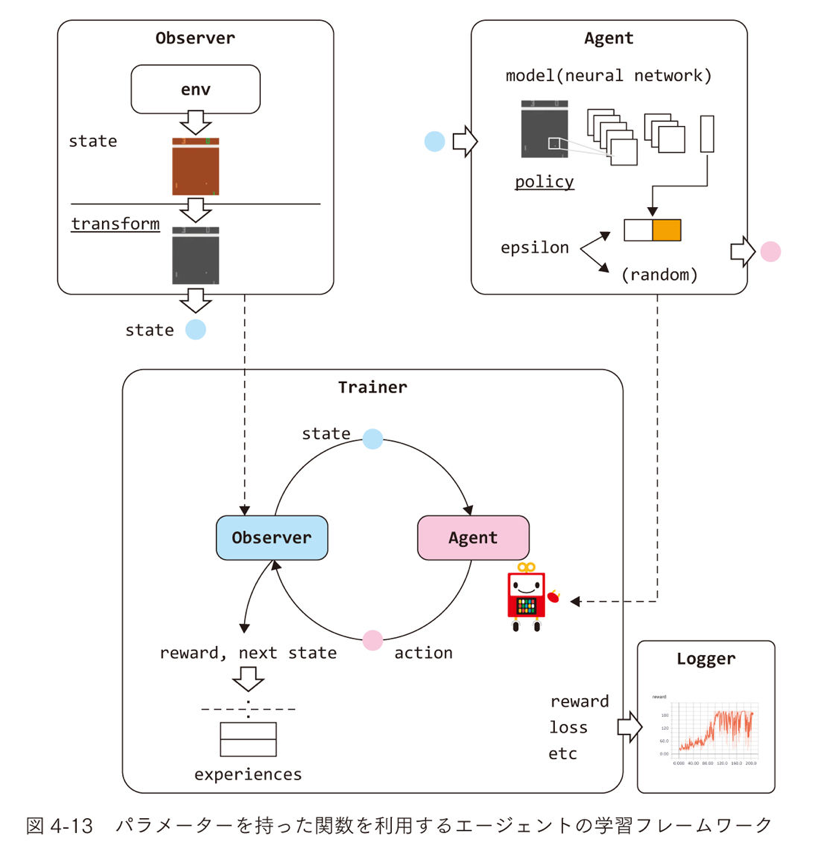

## 強化学習でNNを扱う際の実装フレームワーク
今後、この章で使うDNNは全てここで定義するクラスを継承して作られる  
code 4-7  NNを使った強化学習のフレームワークの定義 ~ Agent ~

整理
* ポリシーに基づいて実際に行動し、その状態における報酬を得る
  * Valueベース(Q-Learningであればepsilon-greedyに基づいて行動している
  * Policyベース(Policy GradientやA2Cであれば、学習したPolicyに基づいて次に取る行動を選択する
* モデルを保持し、モデルに基づいたある状態における価値の予測

In [1]:
import os
import io
import re
from collections import namedtuple, deque
import numpy as np
import tensorflow as tf
from tensorflow.python import keras as K
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

# 【重要】 この後めちゃ使う
# s: 状態, a: 行動, r: 報酬, n_s: 遷移先の状態, d: エピソード終了フラグ
Experience = namedtuple("Experience", ["s", "a", "r", "n_s", "d"])

class FNAgent():

    def __init__(self, epsilon, actions):
        self.epsilon = epsilon
        self.actions = actions
        self.model = None
        self.estimate_probs = False
        self.initialized = False

    def save(self, model_path):
        """学習したagentの保存"""
        self.model.save(model_path, overwrite=True, include_optimizer=False)

    # 【個人的メモ】 classmethodとは: クラス自体から呼び出せる
    # (ex) クラスAが定義されており、hogeというクラスメソッドがある場合、A.hogeでアクセスできる (インスタンス化しなくて良い)
    @classmethod
    def load(cls, env, model_path, epsilon=0.0001):
        """学習したエージェントの読込"""
        actions = list(range(env.action_space.n))
        agent = cls(epsilon, actions)
        agent.model = K.models.load_model(model_path)
        agent.initialized = True
        return agent

    # 実装は継承先のクラスに委任
    def initialize(self, experience):
        """エージェントに内包されているモデルの初期化"""
        raise NotImplementedError("You have to implement initialize method.")

    # 実装は継承先のクラスに委任
    def estimate(self, s):
        """状態sの価値をモデルによって予測する"""
        raise NotImplementedError("You have to implement estimate method.")

    # 実装は継承先のクラスに委任
    def update(self, experiences, gamma):
        """エージェントが実際に行動して得られた報酬による学習"""
        raise NotImplementedError("You have to implement update method.")

    # epsilon_greedy法
    def policy(self, s):
        """行動時の方針
        epsilon_greedy法 確率epsilonでランダムに行動
        1-epsilonの確率で次の行動を行う
        * 予測が行動確率(estimate_prob=True)の場合はその確率に従って行動をサンプリングする
        * ↑でない場合は各状態における価値の中から最大のものを選ぶ
        """
        if np.random.random() < self.epsilon or not self.initialized:
            return np.random.randint(len(self.actions))
        else:
            estimates = self.estimate(s)
            if self.estimate_probs:
                action = np.random.choice(self.actions, size=1, p=estimates)[0]
                return action
            else:
                return np.argmax(estimates)


    def play(self, env, episode_count=5, render=True):
        """実際にエージェントの行動をシミュレーションする関数"""
        for e in range(episode_count):
            s = env.reset()
            done = False
            episode_reward = 0
            while not done:
                if render:
                    env.render()
                a = self.policy(s)
                n_state, reward, done, info = env.step(a)
                episode_reward += reward
                s = n_state
            else:
                print("Get reward {}.".format(episode_reward))

code 4-8 NNを使った強化学習のフレームワークの定義 ~ Trainer ~
* Experience Replay (行動履歴を保存し、それを学習データに使用する)
  * Agentの行動と学習は独立
  * 異なる時系列のデータを同じバッチに入れられる -> 学習の安定につながるとのこと
  
整理
* 実際に行動させて、各状態における報酬を経験として蓄積して学習データを取得する

In [2]:
class Trainer():

    def __init__(self, buffer_size=1024, batch_size=32, gamma=0.9, report_interval=10, log_dir=""):
        self.buffer_size = buffer_size # experiencesの大きさ
        self.batch_size = batch_size
        self.gamma = gamma
        self.report_interval = report_interval
        self.logger = Logger(log_dir, self.trainer_name)
        self.experiences = deque(maxlen=buffer_size) # Agentの行動履歴 dequeがfullなら古い方から捨てる
        self.training = False
        self.training_count = 0
        self.reward_log = []

    # 要解明 (どこかで使われている？ -> 使われてない)
    # property: hoge.trainer_nameで呼び出せるように
    @property
    def trainer_name(self):
        class_name = self.__class__.__name__
        snaked = re.sub("(.)([A-Z][a-z]+)", r"\1_\2", class_name)
        snaked = re.sub("([a-z0-9])([A-Z])", r"\1_\2", snaked).lower()
        snaked = snaked.replace("_trainer", "")
        return snaked

    def train_loop(self, env, agent, episode=200, initial_count=-1,
                   render=False, observe_interval=0):
        """メインの学習ループ
        * 1エピソード(CartPoleの場合は棒が倒れるまで?)終わるまで行動させる
          * この行動の最中、buffer_size分経験が蓄積されたら学習開始しても良いというフラグを立てる
        * 基本的にはbuffer_size分溜まったことを教えるのみで、学習開始のタイミングは変えられるようになっている
          * 実際にモデルがパラメータの更新を行うのはstepだったりepisode_endのところで行われる
        * 
        """
        self.experiences = deque(maxlen=self.buffer_size)
        self.training = False
        self.training_count = 0
        self.reward_log = []
        frames = [] # logger蓄積用

        for i in range(episode):
            s = env.reset()
            done = False
            step_count = 0
            self.episode_begin(i, agent)
            while not done:
                if render:
                    env.render()
                if self.training and observe_interval > 0 and\
                   (self.training_count == 1 or
                    self.training_count % observe_interval == 0):
                    frames.append(s) # observe_intervalの頻度で状態を保存

                a = agent.policy(s)
                n_state, reward, done, info = env.step(a)
                e = Experience(s, a, reward, n_state, done)
                self.experiences.append(e)
                # フラグを立てる
                if not self.training and \
                   len(self.experiences) == self.buffer_size:
                    self.begin_train(i, agent)
                    self.training = True

                self.step(i, step_count, agent, e)

                s = n_state
                step_count += 1
            else:
                self.episode_end(i, step_count, agent)
                # initial_countだけエピソードが終了した際にも学習開始する
                # buffer_size一杯にならなくても行う
                if not self.training and \
                   initial_count > 0 and i >= initial_count:
                    self.begin_train(i, agent)
                    self.training = True
                # frameの内容をloggerに書き出す
                if self.training:
                    if len(frames) > 0:
                        self.logger.write_image(self.training_count,
                                                frames)
                        frames = []
                    self.training_count += 1

    def episode_begin(self, episode, agent):
        pass

    def begin_train(self, episode, agent):
        pass

    def step(self, episode, step_count, agent, experience):
        pass

    def episode_end(self, episode, step_count, agent):
        pass

    def is_event(self, count, interval):
        return True if count != 0 and count % interval == 0 else False

    def get_recent(self, count):
        """最も現在からcount数分の経験をとる"""
        recent = range(len(self.experiences) - count, len(self.experiences))
        return [self.experiences[i] for i in recent]

code 4-9 NNを使った強化学習のフレームワークの定義 ~ Observer ~

整理
* envのラッパー
* envから直接得られた結果ではなく、envから得られた結果をここで加工して、モデルの入力とかに渡す
  * transform: envから得た状態をエージェントが扱いやすい状態にする

In [3]:
class Observer():

    def __init__(self, env):
        self._env = env

    @property
    def action_space(self):
        return self._env.action_space

    @property
    def observation_space(self):
        return self._env.oservation_space

    def reset(self):
        return self.transform(self._env.reset())

    def render(self):
        self._env.render(mode="human")

    def step(self, action):
        n_state, reward, done, info = self._env.step(action)
        return self.transform(n_state), reward, done, info

    def transform(self, state):
        raise NotImplementedError("You have to implement transform method.")

code 4-10 NNを使った強化学習のフレームワークの定義 ~ Logger ~

整理
* 優先度 低い
  * ここはあまり重要ではないので読み飛ばしてもいいかも(でもlogの使い方の勉強にはなりそう)
* TensorBoardで値を参照するための書き出し処理が中心
  * コードの理解のためにtensorboardについて調べる必要ありそう -> TensorBoard結局使えておらず
* describeで価値の獲得状況等を逐一確認

In [4]:
class Logger():

    def __init__(self, log_dir="", dir_name=""):
        self.log_dir = log_dir
        if not log_dir:
            self.log_dir = os.path.join(os.path.dirname("../log/"), "logs")
        if not os.path.exists(self.log_dir):
            os.mkdir(self.log_dir)

        if dir_name:
            self.log_dir = os.path.join(self.log_dir, dir_name)
            if not os.path.exists(self.log_dir):
                os.mkdir(self.log_dir)

        self._callback = tf.compat.v1.keras.callbacks.TensorBoard(
                            self.log_dir)

    @property
    def writer(self):
        return self._callback.writer

    def set_model(self, model):
        self._callback.set_model(model)

    def path_of(self, file_name):
        return os.path.join(self.log_dir, file_name)

    def describe(self, name, values, episode=-1, step=-1):
        mean = np.round(np.mean(values), 3)
        std = np.round(np.std(values), 3)
        desc = "{} is {} (+/-{})".format(name, mean, std)
        if episode > 0:
            print("At episode {}, {}".format(episode, desc))
        elif step > 0:
            print("At step {}, {}".format(step, desc))

    def plot(self, name, values, interval=10):
        indices = list(range(0, len(values), interval))
        means = []
        stds = []
        for i in indices:
            _values = values[i:(i + interval)]
            means.append(np.mean(_values))
            stds.append(np.std(_values))
        means = np.array(means)
        stds = np.array(stds)
        plt.figure()
        plt.title("{} History".format(name))
        plt.grid()
        plt.fill_between(indices, means - stds, means + stds,
                         alpha=0.1, color="g")
        plt.plot(indices, means, "o-", color="g",
                 label="{} per {} episode".format(name.lower(), interval))
        plt.legend(loc="best")
        plt.show()

    def write(self, index, name, value):
        summary = tf.compat.v1.Summary()
        summary_value = summary.value.add()
        summary_value.tag = name
        summary_value.simple_value = value
        self.writer.add_summary(summary, index)
        self.writer.flush()

    def write_image(self, index, frames):
        # Deal with a 'frames' as a list of sequential gray scaled image.
        last_frames = [f[:, :, -1] for f in frames]
        if np.min(last_frames[-1]) < 0:
            scale = 127 / np.abs(last_frames[-1]).max()
            offset = 128
        else:
            scale = 255 / np.max(last_frames[-1])
            offset = 0
        channel = 1  # gray scale
        tag = "frames_at_training_{}".format(index)
        values = []

        for f in last_frames:
            height, width = f.shape
            array = np.asarray(f * scale + offset, dtype=np.uint8)
            image = Image.fromarray(array)
            output = io.BytesIO()
            image.save(output, format="PNG")
            image_string = output.getvalue()
            output.close()
            image = tf.compat.v1.Summary.Image(
                        height=height, width=width, colorspace=channel,
                        encoded_image_string=image_string)
            value = tf.compat.v1.Summary.Value(tag=tag, image=image)
            values.append(value)

        summary = tf.compat.v1.Summary(value=values)
        self.writer.add_summary(summary, index)
        self.writer.flush()


## 4.2 Valueベースの強化学習をNNで実装する
* ここから実際に色々な手法を実装していく

* 価値関数をNNで近似する

### 題材 cart pole
* 一本の縦に立てたポールを倒れないようにカートを位置を調整する
* 状態
  * カートの位置・加速度
  * ポールの角度・倒れる速度(角速度)
* 行動
  * カートを右・左どちらに動かすか (どのくらいの速さでといった速度は？)
* 報酬
  * ポールが倒れていない -> 1 (常に1が単位時間で得られ続けて増えていくイメージ)
* ポールが倒れた時点でエピソード終了

code4-11 ~ value function agent 実装 ~

In [5]:
import random
import argparse
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib
import gym

class ValueFunctionAgent(FNAgent):

    def save(self, model_path):
        """学習済みモデルの保存"""
        joblib.dump(self.model, model_path)

    @classmethod
    def load(cls, env, model_path, epsilon=0.0001):
        """agentの読み込み"""
        actions = list(range(env.action_space.n))
        agent = cls(epsilon, actions)
        agent.model = joblib.load(model_path)
        agent.initialized = True
        return agent

    def initialize(self, experiences):
        """学習モデル、状態の初期化"""
        scaler = StandardScaler()
        # 価値関数
        estimator = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=1) # ノード数が10の隠れ層が2つ
        self.model = Pipeline([("scaler", scaler), ("estimator", estimator)])

        states = np.vstack([e.s for e in experiences])
        self.model.named_steps["scaler"].fit(states) # 状態の正規化

        # Avoid the predict before fit
        # 未学習でpredictを行うとバグってしまうので対策するとのこと
        self.update([experiences[0]], gamma=0)
        self.initialized = True
        print("Done initialization. From now, begin training!")

    def estimate(self, s):
        """学習モデルでの予測"""
        estimated = self.model.predict(s)[0]
        return estimated

    def _predict(self, states):
        """
        その状態における行動の価値を返す
        モデルがないorモデルを読み込む前の場合はランダムな値を返す
        """
        if self.initialized:
            predicteds = self.model.predict(states)
        else:
            size = len(self.actions) * len(states)
            predicteds = np.random.uniform(size=size)
            predicteds = predicteds.reshape((-1, len(self.actions)))
        return predicteds

    def update(self, experiences, gamma):
        """モデルの学習
        fitを使ってパラメータを更新する
        """
        states = np.vstack([e.s for e in experiences])
        n_states = np.vstack([e.n_s for e in experiences])

        estimateds = self._predict(states)
        future = self._predict(n_states)

        # 実際にとった行動についての価値更新
        # memo: e.dはbool型でエピソードが終了しているかどうかをみる
        for i, e in enumerate(experiences):
            reward = e.r
            if not e.d:
                reward += gamma * np.max(future[i]) # TD誤差 alpha=1
            estimateds[i][e.a] = reward

        # Q-tableのように縦に状態、横に行動をとり値は価値を格納したもの
        # 連続的な状態をとる場合、ここが爆発する...?
        estimateds = np.array(estimateds)
        # ここ、pipelineにする必要あったのか？ (バラして使ってよかったのでは？)
        states = self.model.named_steps["scaler"].transform(states)
        self.model.named_steps["estimator"].partial_fit(states, estimateds)
        
        
    # jupyter labで描画させるためにoverlap
    def play(self, env, episode_count=1, render=True):
        action_dic = {0: "left", 1: "right"}
        for e in range(episode_count):
            s = env.reset()
            done = False
            episode_reward = 0
            cnt = 0
            get_num = 0
            play_num = 1
            while not done:
                # 毎回レンダリングすると遅くなるので最初の50回は毎回レンダリングし、その後は50回おきにする
                if render and (cnt < 20):
                    env.render()
                elif render and (cnt % 20 == 0):
                    env.render()
                a = self.policy(s)
                n_state, reward, done, info = env.step(a)
                plt.title(f"episode={e}, action={action_dic[a]}, done={done}, frame={cnt}")
                episode_reward += reward
                s = n_state
                cnt += 1
            else:
                print("Get reward {}.".format(episode_reward))

code4-12 CartPole環境のためのObserver
* 4つの値: 1行4列の形式に成形
    * 次の状態, 報酬, 実行終了かのdoneフラグ, info(←これなに)

In [6]:
class CartPoleObserver(Observer):

    def transform(self, state):
        return np.array(state).reshape((1, -1))
    
    # jupyter labで描画させるためにoverlap
    def render(self):
        # self._env.render(mode="rgb_array")
        plt.imshow(self._env.render(mode="rgb_array"))
        display.display(plt.gcf())
        display.clear_output(wait=True)

code4-13 価値関数の学習を行うtrainerを定義する

In [7]:
class ValueFunctionTrainer(Trainer):

    def train(self, env, episode_count=220, epsilon=0.1, initial_count=-1, render=False):
        actions = list(range(env.action_space.n))
        agent = ValueFunctionAgent(epsilon, actions)
        self.train_loop(env, agent, episode_count, initial_count, render)
        return agent

    def begin_train(self, episode, agent):
        agent.initialize(self.experiences)

    def step(self, episode, step_count, agent, experience):
        if self.training:
            batch = random.sample(self.experiences, self.batch_size)
            agent.update(batch, self.gamma)

    def episode_end(self, episode, step_count, agent):
        """ここでは基本的にロガーで書き込む処理のみ"""
        rewards = [e.r for e in self.get_recent(step_count)] # step_count個の経験に対する価値
        self.reward_log.append(sum(rewards))

        # ログを表示するタイミングをeventとして捉えている
        if self.is_event(episode, self.report_interval):
            recent_rewards = self.reward_log[-self.report_interval:]
            self.logger.describe("reward", recent_rewards, episode=episode)

code4-14 学習を実行するための処理  
TODO: opengymでCartPoleの状況を可視化できるように

In [8]:
import gym

def main(play):
    env = CartPoleObserver(gym.make("CartPole-v0"))
    trainer = ValueFunctionTrainer(log_dir="../FN/logs/")
    path = trainer.logger.path_of("value_function_agent.pkl")

    if play:
        agent = ValueFunctionAgent.load(env, path)
        agent.play(env)
    else:
        trained = trainer.train(env)
        trainer.logger.plot("Rewards", trainer.reward_log, trainer.report_interval)

        trained.save(path)

Get reward 200.0.


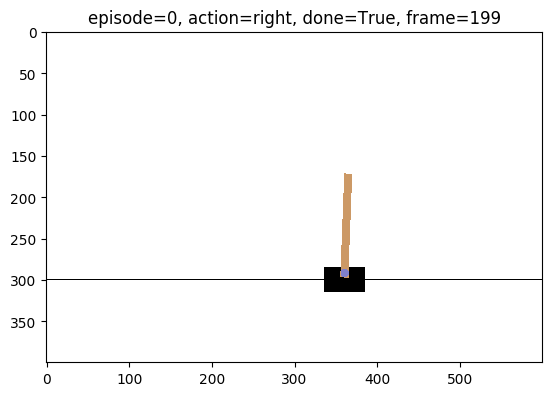

In [9]:
# import argparse
# from IPython import display

parser = argparse.ArgumentParser(description="VF Agent")
parser.add_argument("--play", action="store_true", help="play with trained model")

args = parser.parse_args(args=["--play"])
main(args.play)